# Intro To Time Series

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import scipy.stats
import pylab
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.arima.model import ARIMA
from scipy.stats.distributions import chi2

## Load and Examine Data

In [2]:
df_raw = pd.read_csv("Index2018.csv")
df = df_raw.copy()

In [3]:
df.head()

,date,spx,dax,ftse,nikkei
0,07/01/1994,469.90,2224.95,3445.98,18124.01
1,10/01/1994,475.27,2225.00,3440.58,18443.44
2,11/01/1994,474.13,2228.10,3413.77,18485.25
3,12/01/1994,474.17,2182.06,3372.02,18793.88
4,13/01/1994,472.47,2142.37,3360.01,18577.26


In [4]:
df.date = pd.to_datetime(df.date, dayfirst=True)
df.set_index('date', inplace=True)

In [5]:
df.head()

,spx,dax,ftse,nikkei
date,,,,
1994-01-07,469.90,2224.95,3445.98,18124.01
1994-01-10,475.27,2225.00,3440.58,18443.44
1994-01-11,474.13,2228.10,3413.77,18485.25
1994-01-12,474.17,2182.06,3372.02,18793.88
1994-01-13,472.47,2142.37,3360.01,18577.26


In [6]:
df.describe()

,spx,dax,ftse,nikkei
count,6269.000000,6269.000000,6269.000000,6269.000000
mean,1288.127542,6080.063363,5422.713545,14597.055700
std,487.586473,2754.361032,1145.572428,4043.122953
min,438.920000,1911.700000,2876.600000,7054.980000
25%,990.671905,4069.350000,4486.100000,10709.290000
50%,1233.420000,5773.340000,5662.430000,15028.170000
75%,1459.987747,7443.070000,6304.250000,17860.470000
max,2872.867839,13559.600000,7778.637689,24124.150000


In [7]:
df.isna().sum()

spx       0
dax       0
ftse      0
nikkei    0
dtype: int64

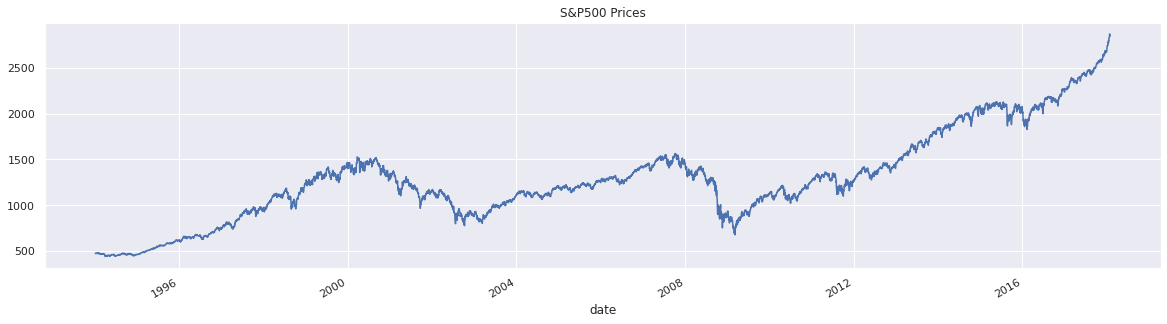

In [8]:
df.spx.plot(figsize=(20,5), title="S&P500 Prices")
plt.show()

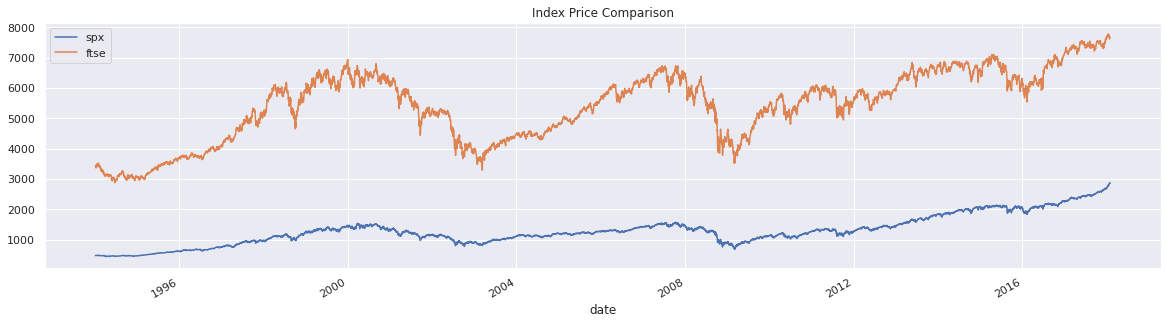

In [9]:
df.spx.plot(figsize=(20,5))
df.ftse.plot(figsize=(20,5))
plt.title("Index Price Comparison")
plt.legend()
plt.show()

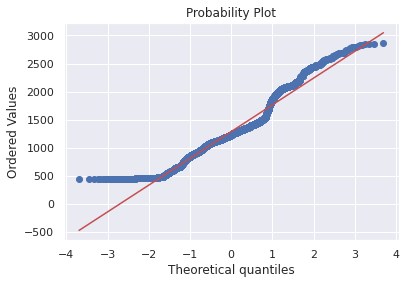

In [10]:
scipy.stats.probplot(df.spx, plot=pylab)
pylab.show()

## Preprocess Data

In [11]:
# Setting the frequency
df = df.asfreq('b') # 'b' for business days

In [12]:
df.isna().sum()

spx       8
dax       8
ftse      8
nikkei    8
dtype: int64

In [13]:
# Fill missing values
df.fillna(method="ffill", inplace=True) # using forwardfill method

In [14]:
# Create a subtable, only showing S&P500 prices
spx = df[["spx"]]
spx.rename(columns={'spx':'price'}, inplace=True);

/home/fathiyul/.local/lib/python3.8/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [15]:
spx.head()

,price
date,
1994-01-07,469.90
1994-01-10,475.27
1994-01-11,474.13
1994-01-12,474.17
1994-01-13,472.47


In [16]:
# Train/Test Split
split_factor = 0.8
n_train = int(len(spx)*split_factor)
spx_train = spx.iloc[:n_train]
spx_test = spx.iloc[n_train:]

In [17]:
spx_train.tail()

,price
date,
2013-04-01,1562.173837
2013-04-02,1570.252238
2013-04-03,1553.686978
2013-04-04,1559.979316
2013-04-05,1553.278930


In [18]:
spx_test.head()

,price
date,
2013-04-08,1563.071269
2013-04-09,1568.607909
2013-04-10,1587.731827
2013-04-11,1593.369863
2013-04-12,1588.854623


## Stationarity Test

In [19]:
sts.adfuller(spx_train.price)

(-1.7369847452352456,
 0.4121645696770613,
 18,
 5002,
 {'1%': -3.431658008603046,
  '5%': -2.862117998412982,
  '10%': -2.567077669247375},
 39904.880607487445)

In [20]:
# Add returns
spx_train['returns'] = spx_train.price.pct_change(1).mul(100)
spx_train = spx_train[1:]

/tmp/ipykernel_40008/2114426197.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spx_train['returns'] = spx_train.price.pct_change(1).mul(100)


In [21]:
sts.adfuller(spx_train.returns)

(-17.03445719098115,
 8.28053702031742e-30,
 17,
 5002,
 {'1%': -3.431658008603046,
  '5%': -2.862117998412982,
  '10%': -2.567077669247375},
 16035.926219345134)

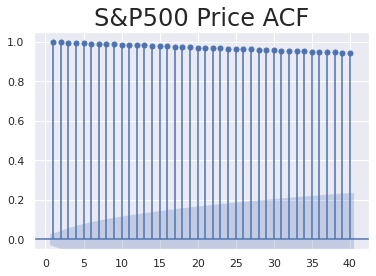

In [22]:
sgt.plot_acf(spx_train.price, lags=40, zero=False)
plt.title("S&P500 Price ACF", size=24)
plt.ylim((-0.05,1.05))
plt.show()

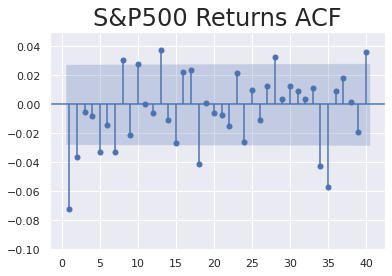

In [23]:
sgt.plot_acf(spx_train.returns, lags=40, zero=False)
plt.title("S&P500 Returns ACF", size=24)
plt.ylim((-0.1,0.05))
plt.show()

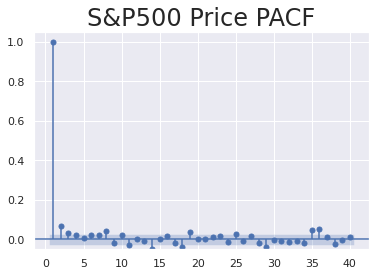

In [24]:
sgt.plot_pacf(spx_train.price, lags=40, zero=False, method=('ols'))
plt.title("S&P500 Price PACF", size=24)
plt.ylim((-0.05,1.05))
plt.show()

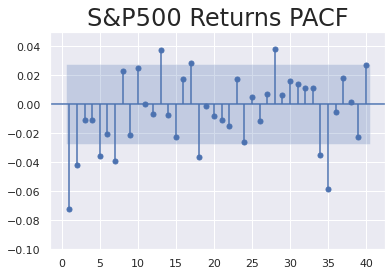

In [25]:
sgt.plot_pacf(spx_train.returns, lags=40, zero=False, method=('ols'))
plt.title("S&P500 Returns PACF", size=24)
plt.ylim((-0.1,0.05))
plt.show()

## AR Models

In [26]:
def ARIMA_fit(series, order=(1,0,1)):
  model = ARIMA(series, order=order)
  result = model.fit()
  print(result.summary())

In [27]:
# AR(1) model
ARIMA_fit(spx_train.returns, order=(1,0,0))

                               SARIMAX Results                                
Dep. Variable:                returns   No. Observations:                 5020
Model:                 ARIMA(1, 0, 0)   Log Likelihood               -8067.541
Date:                Wed, 01 Mar 2023   AIC                          16141.081
Time:                        00:18:54   BIC                          16160.645
Sample:                    01-10-1994   HQIC                         16147.937
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0311      0.016      1.915      0.055      -0.001       0.063
ar.L1         -0.0719      0.008     -8.514      0.000      -0.088      -0.055
sigma2         1.4568      0.013    114.005      0.0

In [28]:
def LLR_test_ARIMA(series, ord1, ord2, DF=1):
  mod1 = ARIMA(series, order=ord1)
  mod2 = ARIMA(series, order=ord2)
  L1 = mod1.fit().llf
  L2 = mod2.fit().llf
  LR = 2*(L2-L1)
  p = chi2.sf(LR, DF).round(3)
  return p

In [29]:
for i in range(10):
  p = i+1
  llr_test_p = LLR_test_ARIMA(spx_train.returns, (p,0,0), (p+1,0,0))
  print(f'LLR Test for AR({p}) vs AR({p+1}): {llr_test_p}')

LLR Test for AR(1) vs AR(2): 0.003
LLR Test for AR(2) vs AR(3): 0.44
LLR Test for AR(3) vs AR(4): 0.452
LLR Test for AR(4) vs AR(5): 0.012
LLR Test for AR(5) vs AR(6): 0.152
LLR Test for AR(6) vs AR(7): 0.006
LLR Test for AR(7) vs AR(8): 0.104
LLR Test for AR(8) vs AR(9): 0.13
LLR Test for AR(9) vs AR(10): 0.079
LLR Test for AR(10) vs AR(11): 0.968


In [30]:
LLR_test_ARIMA(spx_train.returns, (1,0,0), (7,0,0), DF=6)

0.0

In [31]:
model_ar_7 = ARIMA(spx_train.returns, order=(7,0,0))
spx_train['res_return'] = model_ar_7.fit().resid

In [32]:
spx_train.head()

,price,returns,res_return
date,,,
1994-01-10,475.27,1.142796,1.111660
1994-01-11,474.13,-0.239864,-0.191071
1994-01-12,474.17,0.008437,0.003331
1994-01-13,472.47,-0.358521,-0.390783
1994-01-14,474.91,0.516435,0.463560


In [33]:
print("Residuals mean:", spx_train.res_return.mean())
print("Residuals stdev:", spx_train.res_return.std())

Residuals mean: 4.4639638039337446e-05
Residuals stdev: 1.2040185497443938


In [34]:
sts.adfuller(spx_train.res_return)

(-70.77351216723106,
 0.0,
 0,
 5019,
 {'1%': -3.4316535759402753,
  '5%': -2.8621160400844468,
  '10%': -2.567076626752987},
 16032.275178734668)

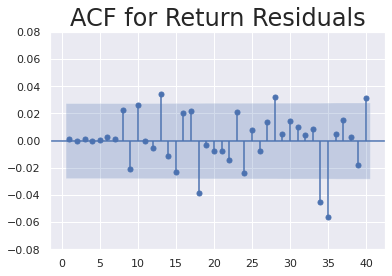

In [35]:
sgt.plot_acf(spx_train.res_return, zero=False, lags=40)
plt.title('ACF for Return Residuals', size=24)
plt.ylim(-0.08,0.08)
plt.show()

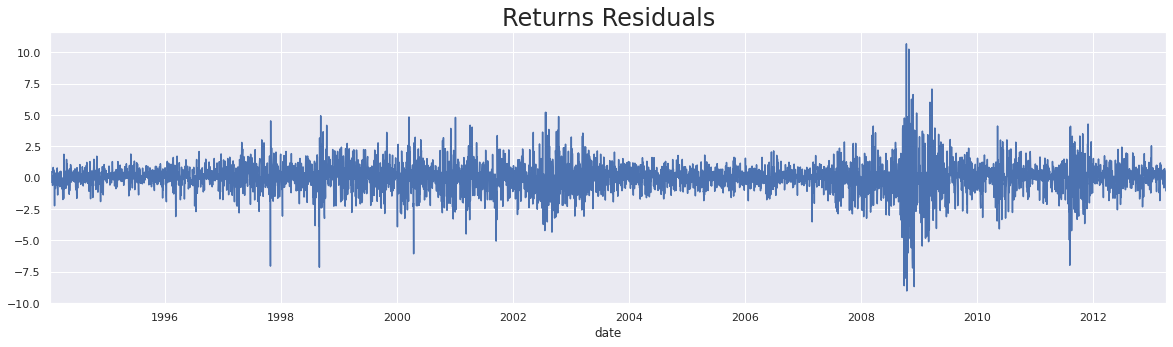

In [36]:
spx_train.res_return.plot(figsize=(20,5))
plt.title('Returns Residuals', size=24)
plt.show()

## MA Models
to be continued